In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# Definir os caminhos para as pastas de treino e teste
caminho_base = 'SOUVIK/'
caminho_treino = caminho_base + 'train/'
caminho_teste = caminho_base + 'test/'
caminho_val = caminho_base + 'val/'


In [11]:

IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# 1. Gerador para os dados de TREINO com Data Augmentation
train_image_generator = ImageDataGenerator(
    rescale=1./255,             # Normaliza os pixels para o intervalo [0, 1]
    rotation_range=45,          # Rotaciona a imagem aleatoriamente em até 45 graus
    width_shift_range=0.2,      # Desloca a imagem na horizontal
    height_shift_range=0.2,     # Desloca a imagem na vertical
    shear_range=0.2,            # Aplica distorções (cisalhamento)
    zoom_range=0.2,             # Aplica zoom aleatório
    horizontal_flip=True,       # Inverte a imagem horizontalmente
    fill_mode='nearest'
)



In [13]:
# 2. Gerador para os dados de TESTE (APENAS normalização)
test_image_generator = ImageDataGenerator(rescale=1./255)
val_image_generator = ImageDataGenerator(rescale=1./255)

# 3. Carregar as imagens dos diretórios usando os geradores
train_data_gen = train_image_generator.flow_from_directory(
    directory=caminho_treino,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary' # Porque temos duas classes (plastic, no-plastic)
)

test_data_gen = test_image_generator.flow_from_directory(
    directory=caminho_teste,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data_gen = val_image_generator.flow_from_directory(
    directory=caminho_val,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 3088 images belonging to 2 classes.
Found 888 images belonging to 2 classes.
Found 186 images belonging to 2 classes.


In [14]:
modelo = Sequential([
    # 1º Bloco Convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    # 2º Bloco Convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # 3º Bloco Convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Camada de achatamento para conectar com as camadas densas
    Flatten(),

    # Camada Densa (Totalmente Conectada)
    Dense(512, activation='relu'),
    
    # Camada de Dropout para regularização
    Dropout(0.5),

    # Camada de Saída
    Dense(1, activation='sigmoid')
])

# Visualizar a arquitetura do modelo
modelo.summary()

c:\Users\jambi\OneDrive\Documentos\repositorios-git\sptech\TCC\machine-learning\cnn-v3\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
modelo.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
# Definir o número de épocas
EPOCHS = 50

# Calcular o número de passos por época
# Total de amostras / Tamanho do lote
steps_per_epoch = train_data_gen.samples // BATCH_SIZE
validation_steps = test_data_gen.samples // BATCH_SIZE

# Treinar o modelo
history = modelo.fit(
    train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=test_data_gen,
    validation_steps=validation_steps
)


c:\Users\jambi\OneDrive\Documentos\repositorios-git\sptech\TCC\machine-learning\cnn-v3\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 64s 655ms/step - accuracy: 0.6247 - loss: 0.6999 - val_accuracy: 0.5405 - val_loss: 0.6954
Epoch 2/50
 1/96 ━━━━━━━━━━━━━━━━━━━━ 25s 267ms/step - accuracy: 0.5000 - loss: 0.7311

c:\Users\jambi\OneDrive\Documentos\repositorios-git\sptech\TCC\machine-learning\cnn-v3\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.5000 - loss: 0.7311 - val_accuracy: 0.5289 - val_loss: 0.7238
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 609ms/step - accuracy: 0.6963 - loss: 0.5751 - val_accuracy: 0.6377 - val_loss: 0.6612
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.6875 - loss: 0.6390 - val_accuracy: 0.6447 - val_loss: 0.6434
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 617ms/step - accuracy: 0.7304 - loss: 0.5263 - val_accuracy: 0.6528 - val_loss: 0.6257
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.7188 - loss: 0.5272 - val_accuracy: 0.6632 - val_loss: 0.6141
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 60s 627ms/step - accuracy: 0.7595 - loss: 0.4950 - val_accuracy: 0.6968 - val_loss: 0.6436
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.8438 - loss: 0.3887 - val_accuracy: 0.6933 - val_loss: 0.6804
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 597ms/step - accuracy: 0.7529 - loss: 0.4954 - val_accuracy: 0.736

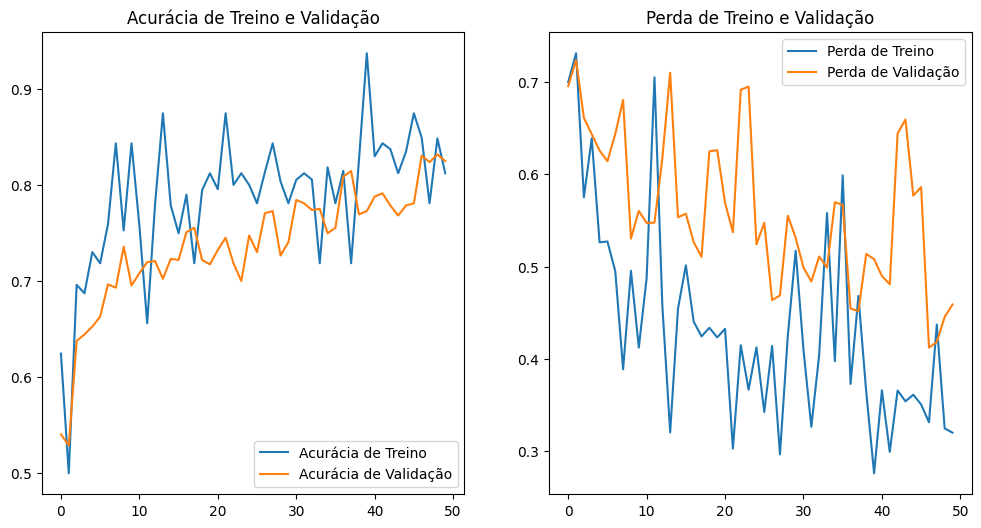

In [17]:
# Pegar os resultados do histórico de treinamento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.show()

In [18]:
modelo.save("modelo_cnn_imagens_de_fora_3_50epochs.keras")